# About

This notebook is to check out the CCA correlation.

For this notebook, 

- View A: 10 dimension
- View B: 1 dimension
- Sample number: 200

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings

import sklearn
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from cca_zoo.models import CCA as cz_CCA
from cca_zoo.models import rCCA as cz_rCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV

rs_num = 43
rng = np.random.default_rng(rs_num)

n_splits = 5
n_repeats = 50

sklearn.set_config(display="diagram")

%matplotlib inline

# 1. Construct Datasets

The following datasets would be used: 
1. All features from view A and view B are i.i.d. random variables
2. 1 feature from view A is correlated with view B
2. 5 features from view A is correlated with view B

Pertubation would be added to view B.

In [2]:
# initialization
n_sample = 200
n_dim_A = 10
n_dim_B = 1
mean = 1.0
scale = 0.2

noise_arr = rng.normal(loc=0.5, scale=0.1, size=(n_sample, n_dim_B))

In [3]:
# construct datasets with Bunch
dataset_1 = Bunch()
dataset_1.view_A = rng.normal(loc=mean, scale=scale, size=(n_sample, n_dim_A))
dataset_1.view_B = rng.normal(loc=mean, scale=scale, size=(n_sample, n_dim_B)) + noise_arr

dataset_2 = Bunch()
dataset_2.view_A = rng.normal(loc=mean, scale=scale, size=(n_sample, n_dim_A))
dataset_2.view_B = (dataset_2.view_A[:, 5] * 0.85).reshape(-1, n_dim_B) + noise_arr

dataset_3 = Bunch()
dataset_3.view_A = rng.normal(loc=mean, scale=scale, size=(n_sample, n_dim_A))
dataset_3.view_B = (
    dataset_3.view_A[:, 2] * 1.1 - dataset_3.view_A[:, 6] * 0.9 + dataset_3.view_A[:, 3] * 2.0 - 
    dataset_3.view_A[:, 5] * 0.1 - dataset_3.view_A[:, 9] * 0.66
).reshape(-1, n_dim_B) + noise_arr

dataset_list = [dataset_1, dataset_2, dataset_3]

# 2. Standardize Datasets

In [4]:
for ds in dataset_list: 
    ds.view_A_standardized = StandardScaler().fit_transform(ds.view_A)
    ds.view_B_standardized = StandardScaler().fit_transform(ds.view_B)

# 3. Fit CCA Models

In [5]:
for ds in dataset_list: 
    ds.cca = cz_CCA(latent_dims=1, random_state=rs_num).fit((ds.view_A_standardized, ds.view_B_standardized))
    ds.view_A_transformed, ds.view_B_transformed = ds.cca.transform((ds.view_A_standardized, ds.view_B_standardized))
    ds.cc = ds.cca.score((ds.view_A_standardized, ds.view_B_standardized))

# 4. Apply Linear Regression on the Transformed Datasets

In [6]:
for ds in dataset_list: 
    ds.lr = LinearRegression().fit(ds.view_A_transformed, ds.view_B_transformed)
    ds.lr_x_test = np.linspace(-4.5, 4.5, 101).reshape(-1, 1)
    ds.lr_y_pred = ds.lr.predict(ds.lr_x_test)
    ds.lr_score = ds.lr.score(ds.view_A_transformed, ds.view_B_transformed)

# 5. Visualize Transformed Data with LR

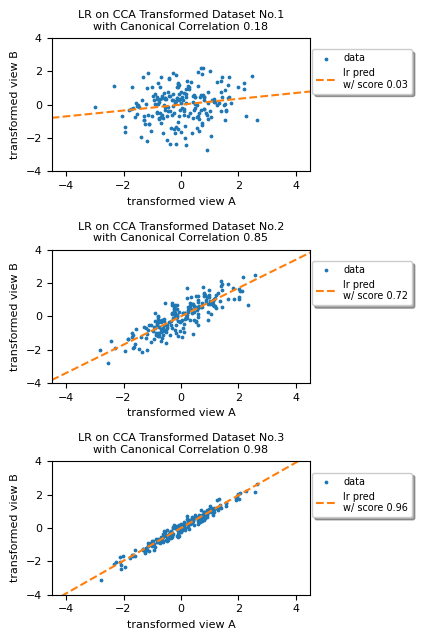

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(4.5, 6.5))
font_size = 8

for i, ds in enumerate(dataset_list): 
    ax = axes[i]
    ax.scatter(
        ds.view_A_transformed, ds.view_B_transformed, marker='.', s=12, label='data'
    )
    ax.plot(
        ds.lr_x_test, ds.lr_y_pred, ls='--', color='tab:orange', label='lr pred\nw/ score {:.2f}'.format(ds.lr_score)
    )
    ax.set_xlim([-4.5, 4.5])
    ax.set_ylim([-4, 4])
    ax.set_xlabel('transformed view A', fontsize=font_size)
    ax.set_ylabel('transformed view B', fontsize=font_size)
    ax.set_title(
        (
            'LR on CCA Transformed Dataset No.{}\n'.format(i+1) + 
            'with Canonical Correlation {:.2f}'.format(ds.cc[0])
        ), 
        fontsize=font_size
    )
    ax.legend(
        loc='upper center', bbox_to_anchor=(1.2, 0.95), 
        fancybox=True, shadow=True, ncol=1, fontsize=(font_size-1)
    )
    ax.tick_params(axis='both', which='both', labelsize=font_size)

fig.tight_layout()